# Big Data in Finance: In-Class Presentation

In [1]:
import time
import pandas as pd
import datetime as dt
import helper_functs as hf
import warnings
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Loading Dataset

In [2]:
tickers = pd.read_excel("data_sources/PERMNO_Tickers.xlsx", index_col="Dates")
tickers.index = pd.to_datetime(tickers.index,  format='%Y%m%d').date
tickers.name = "TICKERS"

flows = pd.read_excel("data_sources/Flows_Clean.xlsx", index_col="Dates")
flows.index = pd.to_datetime(flows.index, format='%Y%m%d').date
flows.name = "FLOWS"

returns = pd.read_excel("data_sources/Returns_Clean.xlsx", index_col="Dates")
returns.index = pd.to_datetime(returns.index,format='%Y%m%d').date
returns.name = "RETURNS"
returns.head()

,55976,41072,27748,75259,40970,62519,21792,54084,55511,10302,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
1993-04-01,-0.019685,0.019391,-0.007282,-0.003891,0.083333,0.027027,0.005348,0.020000,-0.010417,-0.025000,...,0.108108,-0.019048,-0.017857,-0.028269,0.000000,0.006173,-0.023669,0.000000,0.031915,0.014433
1993-04-02,-0.020080,0.002717,-0.002445,0.058594,-0.038462,-0.026316,-0.007979,-0.019608,-0.021053,-0.025641,...,0.000000,-0.016181,-0.031818,-0.010909,0.000000,-0.020450,0.012121,-0.032609,0.020619,-0.010163
1993-04-05,-0.024590,-0.006775,-0.002451,0.022140,-0.040000,0.027027,0.005362,0.000000,0.021505,0.026316,...,-0.048780,-0.003289,0.032864,0.003676,-0.005102,0.018789,-0.005988,-0.011236,-0.010101,0.026694
1993-04-06,-0.067227,0.009550,-0.007371,0.025271,0.041667,0.052632,0.005333,0.000000,0.000000,0.038462,...,-0.025641,-0.023102,-0.009091,-0.007326,0.005128,0.002049,-0.024096,-0.011364,-0.010204,0.014000
1993-04-07,0.000000,0.005405,0.000000,0.021127,0.040000,-0.050000,0.002653,0.000000,0.010526,0.012346,...,-0.013158,0.016892,0.018349,0.000000,0.010204,0.014315,0.000000,0.011494,0.000000,0.005917


# Warm-Up

In [3]:
all_stocks =pd.DataFrame(index=returns.index)

In [4]:
PERMNO = list(returns.columns) #PERMNO is the same everywhere, i.e. tickers, flows, returns
WINDOW_SIZE = 5

### Rolling MA Benchmark

In [ ]:
all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] = 0
SMA_cumulative_RMSE_per_stock= {}
for number in PERMNO:
    stock = hf.create_stock_df(number,[flows, returns,tickers])
    stock_lagged = hf.get_lags(stock, 3).dropna()
    stock_X, stock_Y = hf.x_y_split(stock_lagged)
    stock_SMA = copy.deepcopy(stock_Y)
    stock_SMA.columns = [f'{number}_RETURNS' if x=='RETURNS' else x for x in stock_SMA.columns]
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]=stock_SMA[f'{number}_RETURNS'].rolling(WINDOW_SIZE).mean().shift(1)
    stock_SMA = stock_SMA.dropna()    
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"]=(stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_PRED"]-stock_SMA[f'{number}_RETURNS'])**2
    stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"] = stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] += stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"]
    SMA_cumulative_RMSE_per_stock[number]= stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"].sum()
    all_stocks[stock_SMA.columns]= stock_SMA

In [ ]:
all_stocks[f"SMA_5_CUM_RMSE"]

In [ ]:
plt.plot(all_stocks.index, all_stocks["SMA_5_CUM_RMSE"], label="SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"SMA_25_CUM_RMSE"], label="SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"SMA_250_CUM_RMSE"], label="SMA_250_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

### Rolling Regression

In [ ]:
all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    x_fully = hf.add _features(x_full)
    stock_LM = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.LinearRegression())
    stock_LM.columns = [f'{number}_{WINDOW_SIZE}_LM_{x}' for x in stock_LM.columns]
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"] = (stock_LM[f"{number}_{WINDOW_SIZE}_LM_PRED"]-stock_LM[f'{number}_{WINDOW_SIZE}_LM_RETURNS'])**2
    stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"] = stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] += stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"]
    all_stocks[stock_LM.columns]= stock_LM
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

In [ ]:
all_stocks.columns

In [ ]:
plt.plot(all_stocks.index, all_stocks["LM_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="LM-SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["LM_25_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="LM-SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["LM_250_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="LM-SMA_250_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

### Rolling LASSO

In [ ]:
hyperparameters_LASSO = {'alpha': [1,0.1, 0.01]}

In [ ]:
all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()

for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows, pca_n_components=10)
    stock_LASSO = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.Lasso(alpha=0.5), progession_param=0.3)
    stock_LASSO.columns = [f'{number}_{WINDOW_SIZE}_LASSO_{x}' for x in stock_LASSO.columns]
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"] = (stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_PRED"]-stock_LASSO[f'{number}_{WINDOW_SIZE}_LASSO_RETURNS'])**2
    stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"] = stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] += stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"]
    all_stocks[stock_LASSO.columns]= stock_LASSO
    end = time.time()
    if (i+1) % 10 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

In [ ]:
all_stocks.columns

In [ ]:
plt.plot(all_stocks.index, all_stocks["LASSO_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="LASSO-SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"LASSO_25_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="LASSO-SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"LASSO_250_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="LASSO-SMA_250_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

In [ ]:
hyperparameters_RF = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split':  [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

### Rolling RandomForest

In [ ]:
all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    x_fully = hf.add_features(x_full)
    x_fully['RETURNS'] = hf.make_market_state(x_fully['RETURNS'])
    stock_RF = hf.Normal_ML(WINDOW_SIZE, x_fully,make_pipeline(StandardScaler(), SVC(gamma='auto')))
    stock_RF.columns = [f'{number}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{number}_{WINDOW_SIZE}_RF_RETURNS'])**2
    stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
    all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] += stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"]
    all_stocks[stock_RF.columns]= stock_RF
    end = time.time()
    if (i+1) % 5 == 0:
        print(f"{i+1}/{100}",f"{end-start} seconds have passed")

In [ ]:
plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="RF-SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="RF-SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="RF-SMA_25_CUM_RMSE")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

In [ ]:
all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"].plot()

In [35]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [95]:
stock = hf.create_stock_df(55976,[flows, returns, tickers])
x_small = hf.get_lags(stock, 3).dropna()
x_full = hf.extend_variables(55976, x_small, returns, flows)
x_fully = hf.add_features(x_full)
x_fully['RETURNS'] = hf.make_market_state(x_fully['RETURNS'], tau=0.005)

In [96]:
stock_RF= hf.Normal_ML(WINDOW_SIZE, x_fully,clf)
stock_RF.columns = [f'{55976}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
stock_RF[f"{55976}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{55976}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{55976}_{WINDOW_SIZE}_RF_RETURNS'])**2
stock_RF[f"{55976}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{55976}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
all_stocks[stock_RF.columns]= stock_RF

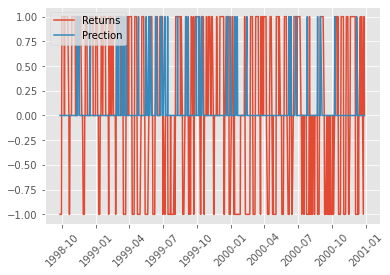

In [97]:
plt.plot(stock_RF.index, stock_RF[f'{55976}_{WINDOW_SIZE}_RF_RETURNS'], label="Returns")
plt.plot(stock_RF.index, stock_RF[f"{55976}_{WINDOW_SIZE}_RF_PRED"], label="Prection")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

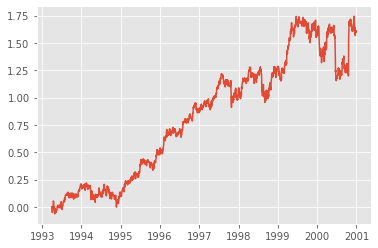

In [74]:
returns[10145].cumsum().plot()

In [85]:
from sklearn.metrics import confusion_matrix

In [98]:
confusion_matrix(stock_RF['55976_5_RF_RETURNS'], stock_RF['55976_5_RF_PRED'])

array([[  0, 148,  14],
       [  0, 181,   6],
       [  0, 198,  25]])

In [ ]:
stock_RF[f"{10145}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{55976}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{55976}_{WINDOW_SIZE}_RF_RETURNS'])**2
stock_RF[f"{10145}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{55976}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5

In [ ]:
stock_RF[f"{55976}_{WINDOW_SIZE}_RF_RMSE"].plot()

In [12]:
tickers

,PERMNO,TICKER,COMNAM
1993-04-01,10145,ALD,ALLIED SIGNAL INC
1993-04-02,10145,ALD,ALLIED SIGNAL INC
1993-04-05,10145,ALD,ALLIED SIGNAL INC
1993-04-06,10145,ALD,ALLIED SIGNAL INC
1993-04-07,10145,ALD,ALLIED SIGNAL INC
...,...,...,...
2000-12-22,90916,BXG,BLUEGREEN CORP
2000-12-26,90916,BXG,BLUEGREEN CORP
2000-12-27,90916,BXG,BLUEGREEN CORP
2000-12-28,90916,BXG,BLUEGREEN CORP
